In [1]:
%load_ext autoreload
%autoreload complete

%matplotlib inline

import function_sleepWakeLabels as sleep
import graphRegularizedSVD_sleepWakeMatrices as gsvd
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob
import re
import warnings
from os.path import join
from pathlib import Path
from datetime import date, datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import seaborn as sns
from dotenv import dotenv_values
import itertools
import pickle
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

sns.set_theme(style="darkgrid")

cfg = dotenv_values()

dat_dir = cfg['DAT_DIR']

/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
dat_kp: pd.DataFrame = pq.read_table(join(dat_dir, 'UnMASCK', 'dat_kp_phone.parquet')).to_pandas()

# Copy to prevent SettingWithCopyWarning
dat_kp = dat_kp.loc[dat_kp['phoneBrand'] == 'iPhone'].copy()

# dat_kp

In [6]:
# Retain the original timestamp column for sanity checks later on
og_keypressTimestampLocal = pd.to_datetime(dat_kp['keypressTimestampLocal'])

dat_kp['keypressTimestampLocal'] = og_keypressTimestampLocal + timedelta(hours = 12)

# Pandas has trouble computing the min of a date, so convert back to datetime
dat_kp['date'] = pd.to_datetime(dat_kp['keypressTimestampLocal'].dt.date)
dat_kp['hour'] = dat_kp['keypressTimestampLocal'].dt.hour

In [ ]:
dat_ses: pd.DataFrame = pq.read_table(join(dat_dir, 'UnMASCK', 'dat_ses_phone.parquet')).to_pandas()

# Copy to prevent SettingWithCopyWarning
dat_ses = dat_ses.loc[dat_ses['phoneBrand'] == 'iPhone'].copy()

# dat_ses

In [9]:
dat_ses['sessionTimestampLocal'] = dat_ses['sessionTimestampLocal'] + timedelta(hours=12)

dat_ses['date'] = pd.to_datetime(dat_ses['sessionTimestampLocal'].dt.date)
dat_ses['hour'] = dat_ses['sessionTimestampLocal'].dt.hour

In [10]:
typing_matrices, dates = gsvd.get_typing_matrices(dat_kp, dat_ses)

# Save to / load from file

In [11]:
typing_mat_dict = {
    "typing_matrices": typing_matrices,
    "dates": dates
}

with open(join(dat_dir, 'UnMASCK', 'typing_mat_dict_2024-11-18.pkl'), 'wb') as f:
    pickle.dump(typing_mat_dict, f)

In [12]:
with open(join(dat_dir, 'UnMASCK', 'typing_mat_dict_2024-11-18.pkl'), 'rb') as f:
    typing_mat_dict = pickle.load(f)

typing_matrices: dict[str, dict[str, pd.DataFrame]] = typing_mat_dict["typing_matrices"]
dates: pd.DataFrame = typing_mat_dict["dates"]

# Calculate GSVDs

In [13]:
alpha = 1

In [14]:
svd_mats, split_indices = gsvd.calculate_svd(
    typing_matrices, alpha=alpha, train_ratio=0.1)

  0%|          | 0/89 [00:00<?, ?it/s]

/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:812: UserWarning: No data in training set for participant 19
  warnings.warn(f"No data in training set for participant {subject}")
/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:812: UserWarning: No data in training set for participant 97
  warnings.warn(f"No data in training set for participant {subject}")


In [15]:
# Saving
with open(join(dat_dir, 'UnMASCK', f"svd_mats_alpha{alpha}_2024-11-18.pkl"), 'wb') as f:
    pickle.dump(svd_mats, f)

In [17]:
# Loading
with open(join(dat_dir, 'UnMASCK', f"svd_mats_alpha{alpha}_2024-11-18.pkl"), 'rb') as f:
    svd_mats: dict[str, dict[str, np.ndarray]] = pickle.load(f)

In [20]:
def plot_mat(df: pd.DataFrame, a: Axes, cbar_label: str, title: str):
    sns.heatmap(df, cmap='viridis', ax=a, vmin=0, #vmax=500,
                cbar_kws={'label': cbar_label, 'fraction': 0.043})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    a.set(title=title, xlabel='Hour', ylabel='Day')

def plot_mats(
        svd_mats: dict[str, np.ndarray], 
        typing_matrices: dict[str, dict[str, pd.DataFrame]], 
        participant: str,
        save: bool = False
    ):

    part_mats = typing_matrices[participant]
    
    n_presses_df = part_mats['n_presses']
    ikd_df = part_mats['IKD']
    active_df = part_mats['active']
    upright_df = part_mats['upright']

    if participant not in svd_mats:
        warnings.warn(f"Participant {participant} has no SVD matrix, skipping")
        return

    split_idx = None
    svd_mat = svd_mats[participant]
    if 'train' in svd_mat:
        # At which day to draw the split lines
        split_idx = svd_mat['train'].shape[0]
        
        svd_mat = np.vstack((
            svd_mat['train'],
            svd_mat['test']
        ))
        
    svd_mat_df = pd.DataFrame(svd_mat, 
                              index=ikd_df.index, 
                              columns=ikd_df.columns)

    plt.rcParams.update({'font.size': 64})
    # Visualize heatmap of steps
    fig, ax = plt.subplots(nrows=3,ncols=2, sharex=False, sharey=False,
                           figsize=(20,25), facecolor='w')

    # PLOT 1
    plot_mat(np.log1p(n_presses_df), ax[0, 0], 
             cbar_label='log(1 + #Keypresses)', title='Input typing activity')

    # PLOT 2
    plot_mat(ikd_df, ax[0, 1], 
             cbar_label='Median IKD (s)', title='Input typing speed')

    # PLOT 3
    plot_mat(upright_df, ax[1, 0], 
             cbar_label='Movement rate', title='Input movement rate')

    # PLOT 4
    plot_mat(active_df, ax[1, 1], 
             cbar_label='Upright rate', title='Input upright rate')

    # PLOT 5
    a = ax[2, 0]
    plot_mat(svd_mat_df, a, 
             cbar_label='Value', title='Graph-regularised SVD')
    
    if split_idx is not None:
        sns.lineplot(x=np.arange(0, 25), y=[split_idx]*25, color='orange', ax=a)

    fig.tight_layout()

    if save:
        fig.savefig(join('images', 'UnMASCK', f"all_mats_train_test_{participant}_alpha{alpha}_2024-11-18.pdf"))

mpl.use('Agg')

for participant in tqdm(typing_matrices):
    plt.close()

    plot_mats(svd_mats, typing_matrices, participant, save=True)

mpl.use('module://matplotlib_inline.backend_inline')

  0%|          | 0/89 [00:00<?, ?it/s]

/scratch/lorkno/slurm_job_46607377/ipykernel_3613332/3577799945.py:23: UserWarning: Participant 19 has no SVD matrix, skipping
  warnings.warn(f"Participant {participant} has no SVD matrix, skipping")
/scratch/lorkno/slurm_job_46607377/ipykernel_3613332/3577799945.py:23: UserWarning: Participant 97 has no SVD matrix, skipping
  warnings.warn(f"Participant {participant} has no SVD matrix, skipping")


In [ ]:
# These plots are not as pretty as the CLEAR-3 ones
for participant in svd_mats:
    plt.close()
    sns.histplot(svd_mats[participant]['test'].flatten())
    plt.title(participant)
    plt.show()

# Create hour estimates

In [ ]:
activity_scores = dict()

for participant, mats in svd_mats.items():
    # Construct train-test labels
    n_train = mats['train'].shape[0]
    n_test = mats['test'].shape[0]
    labels = ['train'] * n_train + ['test'] * n_test

    # Fuse train and test data
    svd_mat = np.vstack((mats['train'], mats['test']))

    # Convert to DataFrame
    ikd_index = typing_matrices[participant]['IKD'].index
    svd_df = pd.DataFrame(svd_mat, index=ikd_index)

    # Sum over the rows, add train-test labels
    scores = svd_df.sum(axis=1).to_frame(name='activity')
    scores['label'] = labels

    # Binarize data, add to scores DataFrame
    binary_df = svd_df > 1 # np.mean(svd_mat)
    hour_estimates = 24 - binary_df.sum(axis=1)
    scores['hour_estimate'] = hour_estimates

    # Add some measures of data quantity
    n_presses_mat = typing_matrices[participant]['n_presses']
    
    scores['n_total_presses'] = n_presses_mat.sum(axis=1)
    scores['n_active_hours'] = (n_presses_mat > 0).sum(axis=1)

    # plt.close()
    # sns.heatmap(binary_df)
    # plt.show()

    activity_scores[participant] = scores

activity_scores = pd.concat(activity_scores, names=['subject'])

# activity_scores

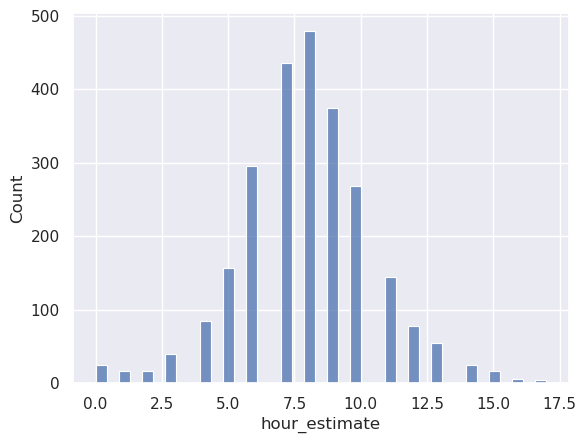

In [23]:
sns.histplot(activity_scores, x='hour_estimate')
plt.show()

In [ ]:
dates['date'] = pd.to_datetime(dates['date'])

date_df = dates.set_index(['subject', 'dayNumber']) \
    .join(activity_scores) \
    .reset_index()

date_df['date'] = date_df['date'].dt.date

# date_df

In [34]:
# No objective sleep data to couple to, so just save to file
date_df.to_parquet(join(dat_dir, 'UnMASCK', f"spleep_pred_10_90_alpha{alpha}_2024-11-18.parquet"))